In [149]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [150]:
train_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv',parse_dates=['trans_date_trans_time',])
test_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')


In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [152]:
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [153]:
#First checking for duplicate and null values:

print(train_data[train_data.duplicated() == True])
#as we can see here, we have no duplicated rows

print(train_data.isnull().sum())
#as we can see here, we have no null value inside any column

Empty DataFrame
Columns: [Unnamed: 0, trans_date_trans_time, cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, trans_num, unix_time, merch_lat, merch_long, is_fraud]
Index: []

[0 rows x 23 columns]
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [154]:
print(train_data.dtypes)

Unnamed: 0                        int64
trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                              object
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
dtype: object


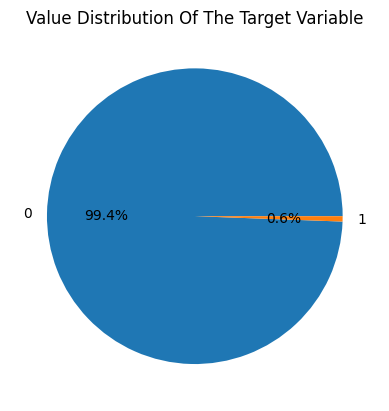

In [155]:
data = train_data['is_fraud'].value_counts()

plt.pie(data, labels=data.index, autopct='%1.1f%%')
plt.title("Value Distribution Of The Target Variable")
plt.show()


In [156]:
train_data.describe()

,Unnamed: 0,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1296675,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,2019-10-03 12:47:28.070214144,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
min,0.000000e+00,2019-01-01 00:00:18,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,2019-06-03 19:12:22.500000,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,2019-10-03 07:35:47,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,2020-01-28 15:02:55.500000,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,2020-06-21 12:13:37,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00
std,3.743180e+05,NaN,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02


In [157]:
print('Summary statistics of non-fraudulent transactions:')
non_fraud_dataSet = train_data[train_data['is_fraud'] == 0]
non_fraud_dataSet.describe()

Summary statistics of non-fraudulent transactions:


,Unnamed: 0,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.289169e+06,1289169,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1289169.0
mean,6.484732e+05,2019-10-03 14:09:52.970105344,4.172901e+17,6.766711e+01,4.880511e+04,3.853689e+01,-9.022814e+01,8.877523e+04,1.349249e+09,3.853666e+01,-9.022827e+01,0.0
min,0.000000e+00,2019-01-01 00:00:18,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.0
25%,3.246100e+05,2019-06-03 21:30:22,1.800429e+14,9.610000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338759e+09,3.473145e+01,-9.689853e+01,0.0
50%,6.484110e+05,2019-10-03 08:50:28,3.521417e+15,4.728000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349254e+09,3.936528e+01,-8.744091e+01,0.0
75%,9.723990e+05,2020-01-28 13:02:30,4.642255e+15,8.254000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359378e+09,4.195705e+01,-8.023853e+01,0.0
max,1.296674e+06,2020-06-21 12:13:37,4.992346e+18,2.894890e+04,9.978300e+04,6.568990e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.668291e+01,-6.695090e+01,0.0
std,3.741526e+05,NaN,1.308990e+18,1.540080e+02,2.689099e+04,5.075234e+00,1.375598e+01,3.018065e+05,1.283514e+07,5.109144e+00,1.376794e+01,0.0


In [158]:
print('Summary statistics of fraudulent transactions:')
fraud_dataSet = train_data[train_data['is_fraud'] == 1]
fraud_dataSet.describe()

Summary statistics of fraudulent transactions:


,Unnamed: 0,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,7.506000e+03,7506,7.506000e+03,7506.000000,7506.000000,7506.000000,7506.000000,7.506000e+03,7.506000e+03,7506.000000,7506.000000,7506.0
mean,6.249497e+05,2019-09-23 16:52:32.620303872,4.003577e+17,531.320092,48038.714229,38.663609,-89.916041,9.727676e+04,1.348389e+09,38.653901,-89.915808,1.0
min,2.449000e+03,2019-01-02 01:06:37,6.041621e+10,1.060000,1330.000000,20.027100,-165.672300,2.300000e+01,1.325466e+09,19.425114,-166.550779,1.0
25%,2.398565e+05,2019-04-29 23:52:24.750000128,1.800429e+14,245.662500,24927.000000,35.056100,-96.701000,7.465000e+02,1.335744e+09,35.114671,-96.671038,1.0
50%,6.381620e+05,2019-09-28 22:47:35.500000,3.528041e+15,396.505000,46290.000000,39.433600,-86.691900,2.623000e+03,1.348872e+09,39.427008,-86.813044,1.0
75%,9.849215e+05,2020-02-04 23:41:28,4.651007e+15,900.875000,71107.000000,42.073175,-79.941600,2.143700e+04,1.360021e+09,41.986902,-79.907096,1.0
max,1.295733e+06,2020-06-21 03:59:46,4.992346e+18,1376.040000,99783.000000,66.693300,-68.556500,2.906700e+06,1.371787e+09,67.510267,-67.569238,1.0
std,4.010560e+05,NaN,1.276871e+18,390.560070,27265.558212,5.172289,14.278221,3.265815e+05,1.383020e+07,5.218387,14.298685,0.0


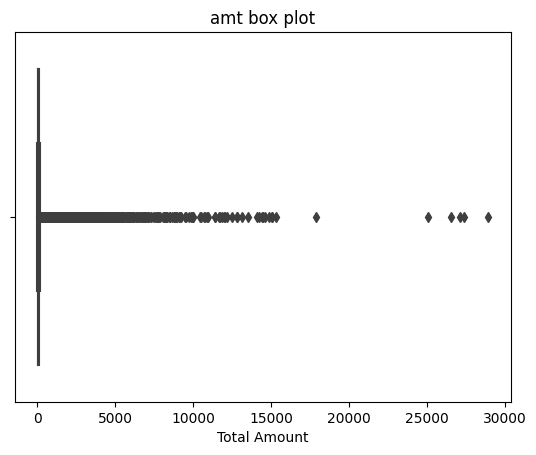

In [159]:
sns.boxplot(x = train_data['amt'])
plt.title('amt box plot')
plt.xlabel('Total Amount')
plt.show()


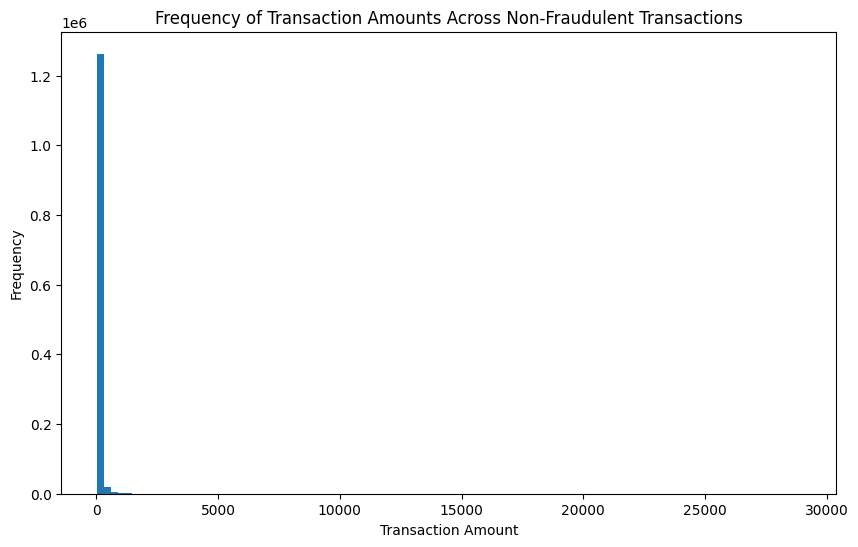

In [160]:
non_fraud_dataSet = train_data[train_data.is_fraud == 0]
data = non_fraud_dataSet['amt']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Transaction Amounts Across Non-Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

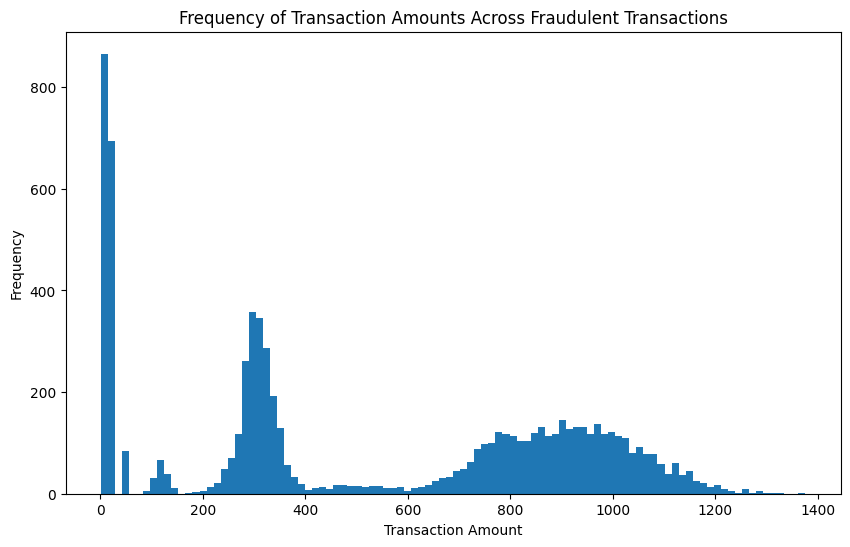

In [161]:
fraud_dataSet = train_data[train_data.is_fraud == 1]
data = fraud_dataSet['amt']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Transaction Amounts Across Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


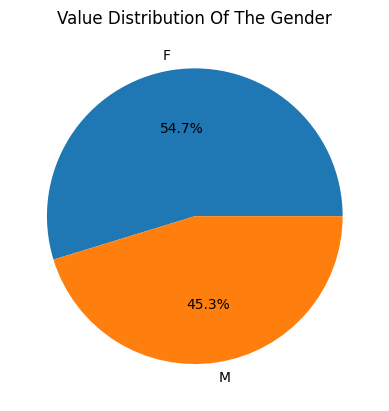

<Figure size 1000x600 with 0 Axes>

In [162]:
data = train_data['gender'].value_counts()

plt.pie(data, labels=data.index, autopct='%1.1f%%')
plt.title("Value Distribution Of The Gender")
plt.figure(figsize=(10, 6))
plt.show()


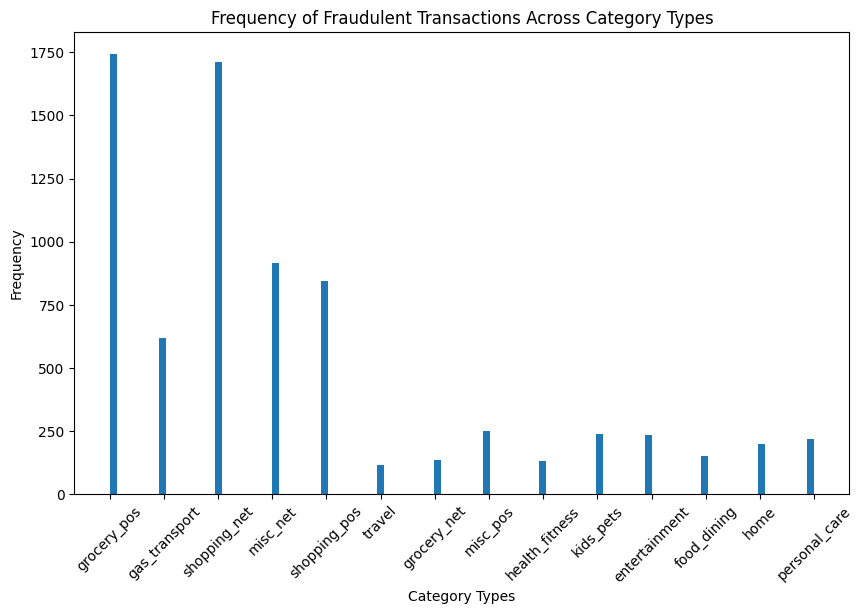

In [163]:
fraud_dataSet = train_data[train_data['is_fraud'] == 1]

data = fraud_dataSet['category']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Fraudulent Transactions Across Category Types')
plt.xlabel('Category Types')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

Adding Hour Features

In [164]:
train_data['hour'] = train_data.trans_date_trans_time.dt.hour

In [165]:
train_data['hourEnc'] = 0
train_data.loc[train_data.hour < 5,'hourEnc'] = 1
train_data.loc[train_data.hour > 21,'hourEnc'] = 1

In [166]:
# Assuming 'trans_date_trans_time' is a datetime column
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])

# Sorting the DataFrame based on the transaction time
train_data.sort_values(by='trans_date_trans_time', inplace=True)

# Adding frequencies for last 1, 7, and 30 days
train_data['transactions_last_1d'] = train_data['trans_date_trans_time'].rolling(window=1).count()
train_data['transactions_last_7d'] = train_data['trans_date_trans_time'].rolling(window=7).count()
train_data['transactions_last_30d'] = train_data['trans_date_trans_time'].rolling(window=30).count()

# Filling NaN values with 0 for the initial rows with no history
train_data['transactions_last_1d'].fillna(0, inplace=True)
train_data['transactions_last_7d'].fillna(0, inplace=True)
train_data['transactions_last_30d'].fillna(0, inplace=True)

In [167]:
# Assuming credit_card_data is your DataFrame
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])

def last1DayTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=1).count()

def last7DaysTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=7).count()

def last30DaysTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=30).count()

# Group by 'cc_num' and apply the custom functions
df1 = train_data.groupby('cc_num').apply(last1DayTransactionCount)
df1 = train_data.groupby('cc_num').apply(last7DaysTransactionCount)
df1 = train_data.groupby('cc_num').apply(last30DaysTransactionCount)

# Resetting the index to obtain a DataFrame
df1 = df1.reset_index(level=0, drop=True)

In [168]:
# Assuming credit_card_data is your DataFrame
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])

def last1DayTransactionCount(group):
    return group.resample('1D', on='trans_date_trans_time').size()

def last7DaysTransactionCount(group):
    return group.resample('7D', on='trans_date_trans_time').size()

def last30DaysTransactionCount(group):
    return group.resample('30D', on='trans_date_trans_time').size()

def timeSinceLastTransaction(group):
    return group['trans_date_trans_time'].diff().dt.total_seconds()

# Group by 'cc_num' and apply the custom functions
df1 = train_data.groupby('cc_num').apply(last1DayTransactionCount)
df1 = train_data.groupby('cc_num').apply(last7DaysTransactionCount)
df1 = train_data.groupby('cc_num').apply(last30DaysTransactionCount)
df1['time_diff'] = train_data.groupby('cc_num').apply(timeSinceLastTransaction)

# Resetting the index to obtain a DataFrame
df1 = df1.reset_index(level=0, drop=True)

**Displaying the correlation between the features**

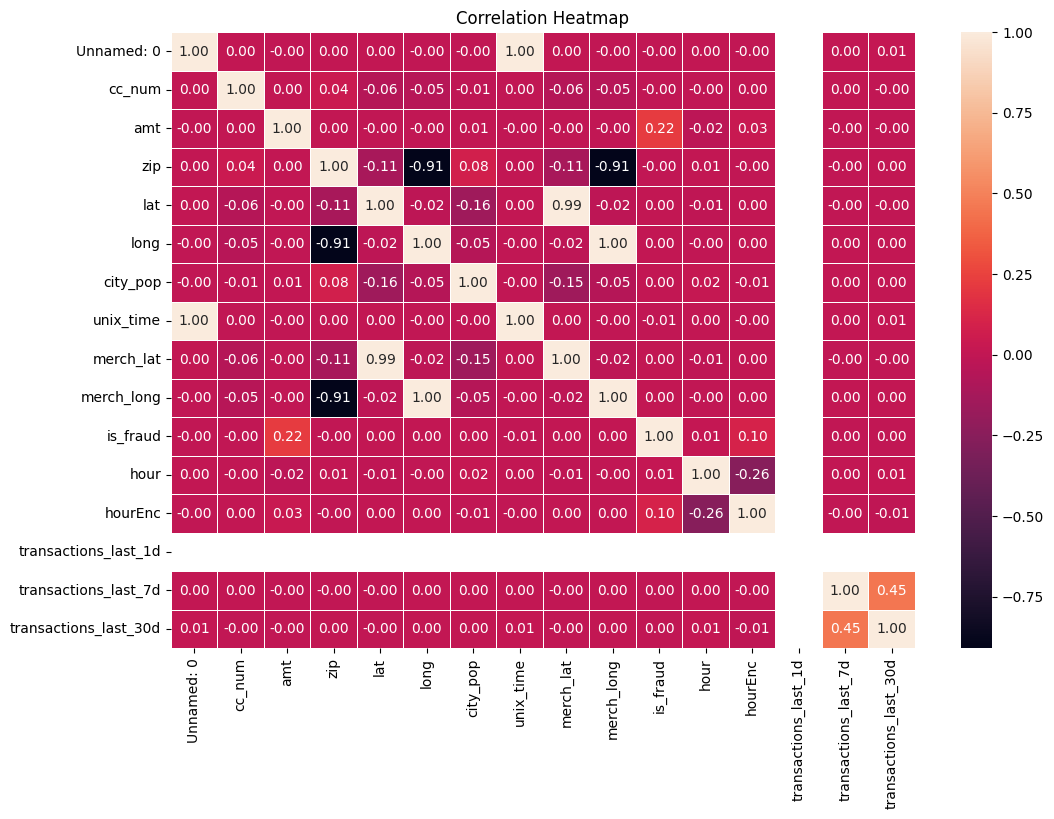

In [169]:
# Drop non-numeric columns
numeric_data = train_data.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Plotting a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [170]:
numeric_columns = train_data.select_dtypes(include='number')
fraud_correlation = numeric_columns.corr()['is_fraud'].abs().sort_values(ascending=False)

print(fraud_correlation)

is_fraud                 1.000000
amt                      0.219404
hourEnc                  0.101077
hour                     0.013799
unix_time                0.005078
Unnamed: 0               0.004767
zip                      0.002162
city_pop                 0.002136
lat                      0.001894
merch_lat                0.001741
merch_long               0.001721
long                     0.001721
cc_num                   0.000981
transactions_last_30d    0.000361
transactions_last_7d     0.000164
transactions_last_1d          NaN
Name: is_fraud, dtype: float64


In [171]:
# Load train and test datasets
train_ds = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
test_ds = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

# Drop non-numeric and non-binary columns for simplicity
numeric_columns_train = train_ds.select_dtypes(include='number')
numeric_columns_test = test_ds.select_dtypes(include='number')

X_train = numeric_columns_train.drop(['is_fraud'], axis=1)
y_train = train_ds['is_fraud']

X_test = numeric_columns_test.drop(['is_fraud'], axis=1)
y_test = test_ds['is_fraud']

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.9959961779244546
Confusion Matrix:
[[553494     80]
 [  2145      0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

